Hourly Sharpe Ratio 1.9267643620582455
Current Balance 11039.784899629969
Starting Balance 10000
Net Return 1.103978489962997
Winrate 76.47058823529412


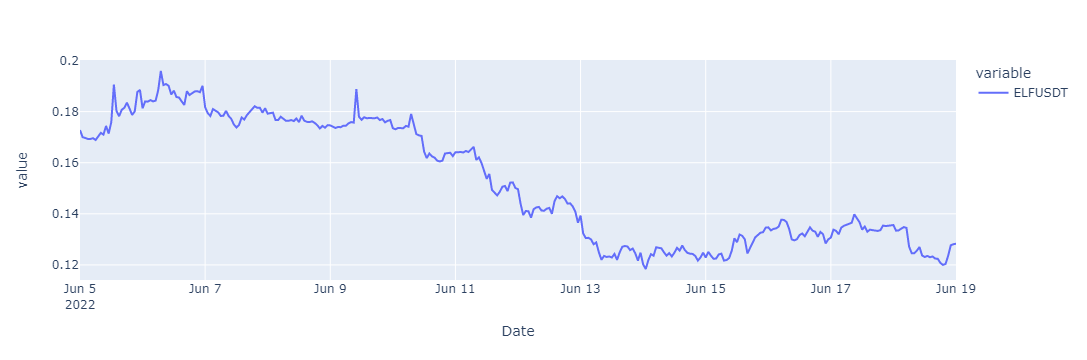

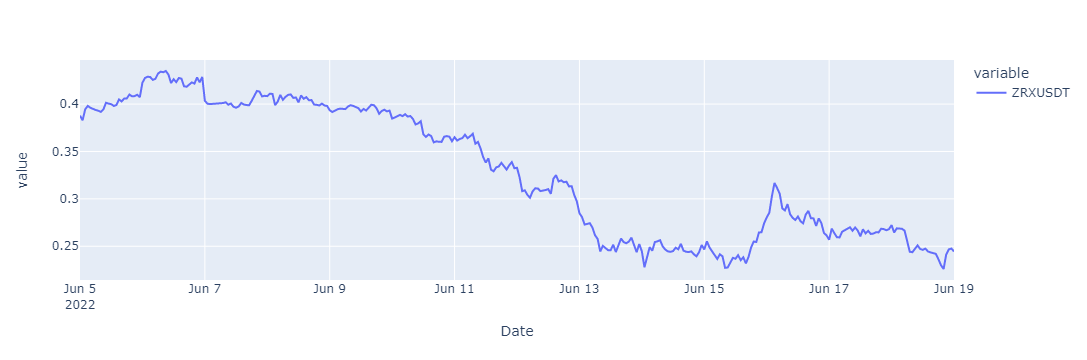

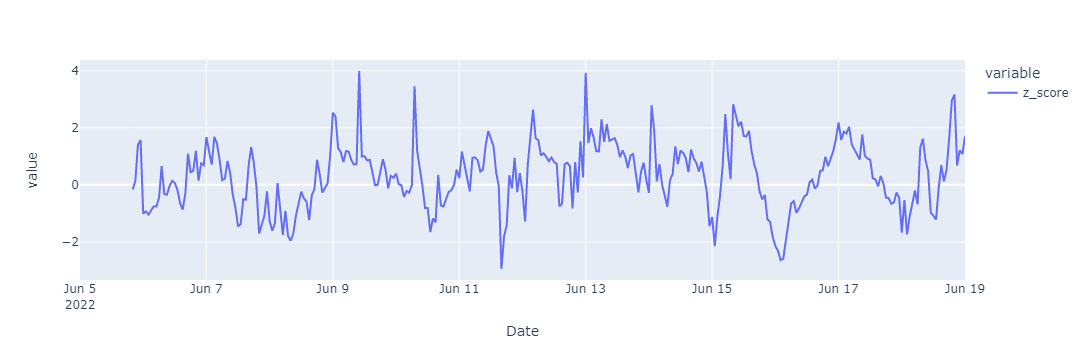

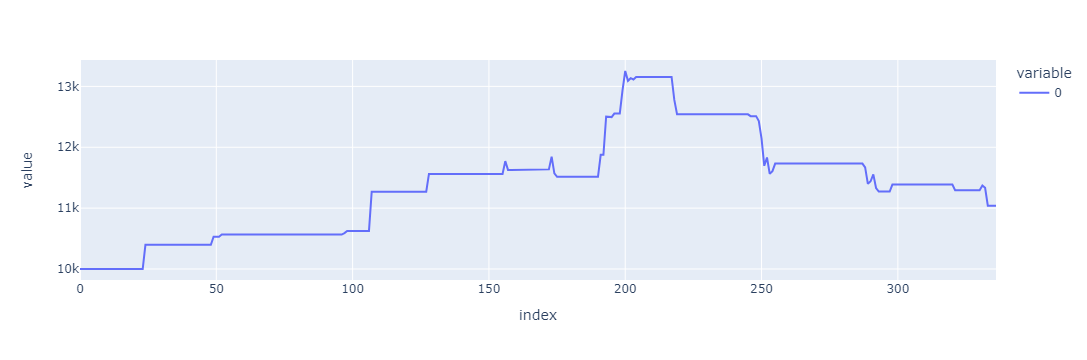

In [18]:
# import libraries
from binance.client import Client
import pandas as pd
import numpy as np
import plotly.express as px
from selenium.webdriver.common.keys import Keys

# initialize Binance API
api_key = "'JCoYhkwlhS6VuGlBLipNkup8HyZ80AKZmnNkbJ3t2jwkbS9ULCufj1dS8gLT1Baq'" 
api_secret = "'qapsxymK6NGYJCHAd26FRSwrk4SZhjjc2BaO1Q2a2rPBPgXOCk1MKJvVItFrCSoy'" 
client = Client(api_key, api_secret)

# define query variables
symbol2 = "ELFUSDT"
symbol3 = "ZRXUSDT"
from_date = "05, June 2022"
to_date = "19, June 2022"

# define algorithm variables
current_balance = starting_capital = 10000
rolling_window = 21
z_score_buy_threshold = -3
z_score_short_threshold = 1.5
transaction_fee = 0 #0.0750 / 100

# pull and format data
def get_data(symbol):
    candles = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1HOUR, from_date, to_date)
    df_ticker = pd.DataFrame(candles)
    df_ticker = df_ticker.iloc[:, [0, 4]]
    df_ticker[0] = df_ticker[0] / 1000
    df_ticker[0] = pd.to_datetime(df_ticker[0], unit='s')
    df_ticker.columns = ["Date", symbol]
    df_ticker = df_ticker.set_index("Date")
    return df_ticker

# get datasets
dt_2 = get_data(symbol2)
dt_3 = get_data(symbol3)

# combine data
df_ticker_main = dt_2.join(dt_3)
df_ticker_main = df_ticker_main.dropna()
df_ticker_main = df_ticker_main.astype(float)

# calculate z score
df_ticker_main[symbol2 + "_Log"] = np.log(df_ticker_main[symbol2])
df_ticker_main[symbol3 + "_Log"] = np.log(df_ticker_main[symbol3])
df_ticker_main["Distance"] = df_ticker_main[symbol2 + "_Log"] - df_ticker_main[symbol3 + "_Log"]
df_ticker_main["Mean_Dist"] = df_ticker_main["Distance"].rolling(rolling_window).mean()
df_ticker_main["Std_Dist"] = df_ticker_main["Distance"].rolling(rolling_window).std()
df_ticker_main["z_score"] = (df_ticker_main["Distance"] - df_ticker_main["Mean_Dist"]) / df_ticker_main["Std_Dist"]

# determine trades
open_orders = net_return = net_change = buy_price = short_price = counts = time_period = sell_price = 0
index_length = len(df_ticker_main)
balance_list = []
returns_list = []
for index, row in df_ticker_main.iterrows():
    current_price = row[symbol2]
    z_score = row["z_score"]

    # stop when balance reduces and
    if current_balance > 0.1 and counts < (index_length - z_score):

        # close any open buy positions
        if open_orders == 1 and z_score_short_threshold:
            sell_price = current_price
            net_return = (sell_price / buy_price)
            net_change = (sell_price - buy_price) / buy_price
            current_balance = current_balance * (1 - transaction_fee) * net_return
            returns_list.append(net_change)
            open_orders = 0

        # close any open short positions
        if open_orders == 2 and z_score_buy_threshold:
            sell_price = current_price
            net_return = (short_price / sell_price)
            net_change = (short_price - sell_price) / short_price
            current_balance = current_balance * (1 - transaction_fee) * net_return
            returns_list.append(net_change)
            open_orders = 0

        # calculate buy's
        if open_orders == 0 and z_score <= z_score_buy_threshold:
            buy_price = current_price
            open_orders = 1

        # calculate shorts's
        if open_orders == 0 and z_score >= z_score_short_threshold:
            short_price = current_price
            open_orders = 2

        # print trade information
        dfr = (counts, "Balance " + str(current_balance), "Buy Price " + str(buy_price)
              , "Sell Price " + str(sell_price), "Net Return " + str(net_return))

    # increment index
    balance_list.append(current_balance)

    counts += 1

# calculate Sharpe Ratio
mean_return = np.average(returns_list)
std_return = np.std(returns_list)
sharpe_ratio = mean_return / std_return
sharpe_ratio_hourly = np.sqrt(365) * sharpe_ratio

#Calculate WinRate
win = 5.5
lost = 1
win = win + 1
lost= lost + 1
amount = 300
amount = amount + (win * 0.10)
amount = amount - (lost * 0.10)


# print results
dfr = print("Hourly Sharpe Ratio", round(sharpe_ratio_hourly, 300))
dfr = print("Current Balance", round(current_balance, 300))
dfr = print("Starting Balance", round(starting_capital, 300))
dfr = print("Net Return", round(current_balance / starting_capital, 300))
dfr = print('Winrate', win / (win + lost) * 100)
dfr = pd.DataFrame

# plot symbol 2
fig = px.line(df_ticker_main[symbol2])
fig.show()

# plot symbol 3
fig = px.line(df_ticker_main[symbol3])
fig.show()

# plot z-score
fig = px.line(df_ticker_main["z_score"])
fig.show()

# plot balance
fig = px.line(balance_list)
fig.show()

In [8]:
df_ticker_main.to_csv('ELFZRX.csv')

In [3]:
BL2 = balance_list.T

AttributeError: 'list' object has no attribute 'T'

In [ ]:
BL2